# Group 14 - Project FP01
## Time series anomaly detection - Bayesian Model

This project aims at investigating the current state-of-the-arts TAD scenario.

In [24]:
!pip install pandas==1.5.3
!pip install tsfel
!pip install keras_tuner
!pip install -U kaleido

In [25]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals
from bayesian_model import BayesianMLPClassifier
from metrics import Confidence, anomaly_detection_metric

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

Mounted at /content/drive


In [26]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

In [27]:
# Dataset frequency
#freq_1s = '1.0'   # Dies at y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
freq_01s = '0.1'
freq_001s = '0.01'
freq_0005s = '0.005'

### Data Loading

In [28]:
freq = freq_01s
#for freq in [freq_01s, freq_001s]:
#  for r in [1, 5]:
#    filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv")]
#    filepath_meta = [os.path.join(ROOTDIR_DATAS/home/h4r/Desktop/machine-learning-in-applications/MLinAPP-FP01-14/src/test_bayesian.ipynbET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata")]
#    df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)
#    plot_signals(df, df_action, title=f"Collisions_rec{r}_{freq}s", saveplot=True)

filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)
#plot_signals(df, df_action, title=f"rec0234_{freq}s")
#df_action.head(2)

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [29]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 241.1266303062439 seconds ---


X_train shape: (729, 2200)
y_train shape: (729,)
X_test shape: (244, 2200)
y_test shape: (244,)


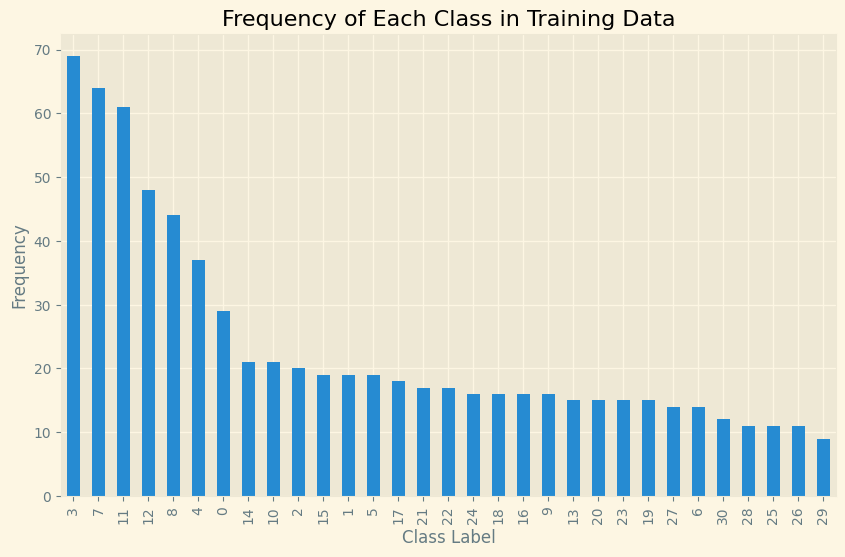

X_train shape: (729, 80)
y_train categorical shape: (729, 31)
y_train shape: (729,)
X_test shape: (244, 80)
y_test shape: (244,)


In [44]:
df_features.isnull().values.any()
#df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()), axis=1)
df_features_nonan = df_features.fillna(0)
df_train, df_test = train_test_split(df_features_nonan)
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Count the occurrence of each class
label_counts = y_train.value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Frequency of Each Class in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()

# Normalize features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train categorical shape: {y_train_categorical.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

input_shape = (X_train.values.shape[1],)
num_classes = len(y_train_categorical[0])

### Bayesian MLP for Anomaly Detection from Lab 7

In [47]:
classifier = BayesianMLPClassifier(input_shape, num_classes)
classifier.setup_tuner()

classifier.search(X_train.values, y_train_categorical)
y_test_pred = classifier.predict(X_test.values)

Trial 90 Complete [00h 00m 13s]
accuracy: 0.403292179107666

Best accuracy So Far: 0.9506173133850098
Total elapsed time: 00h 06m 34s
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense (Dense)               (None, 128)               10368     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0   

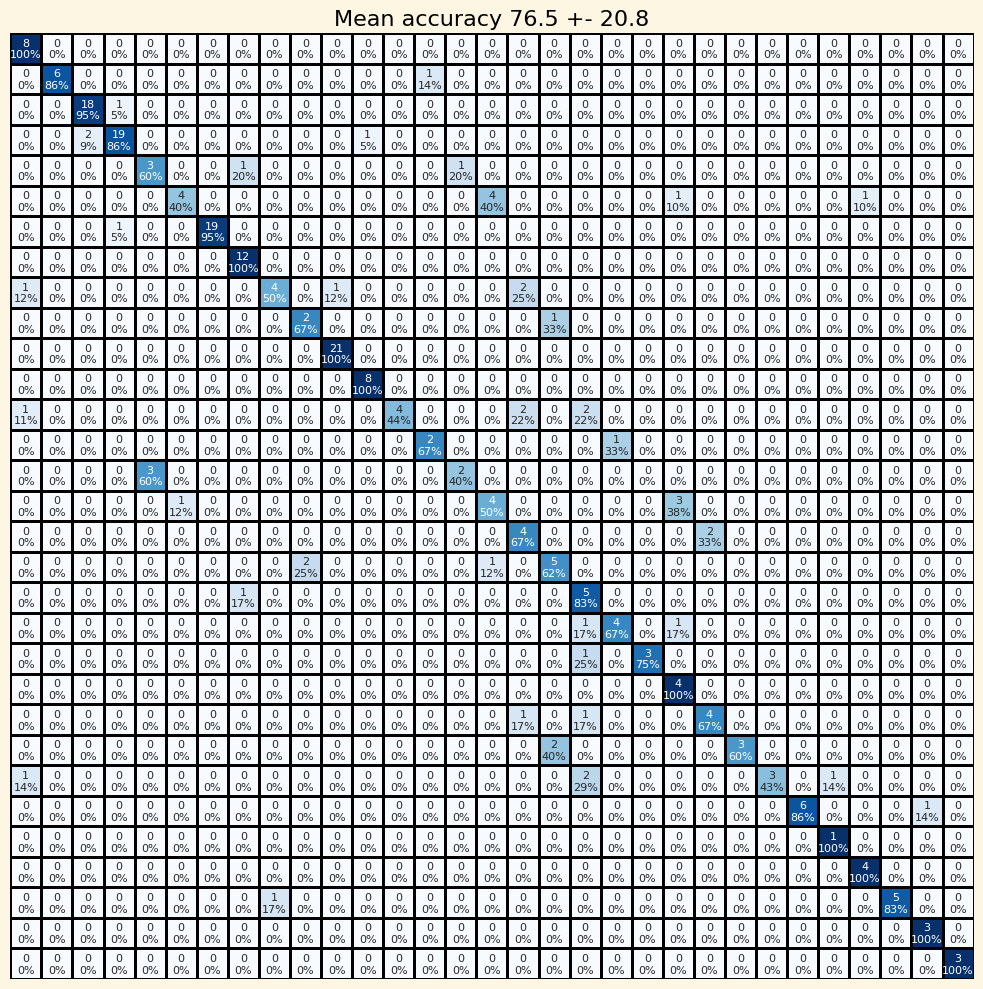

In [48]:
create_and_plot_cm(y_test_pred, y_test, action2int)

(10, 244, 31)
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


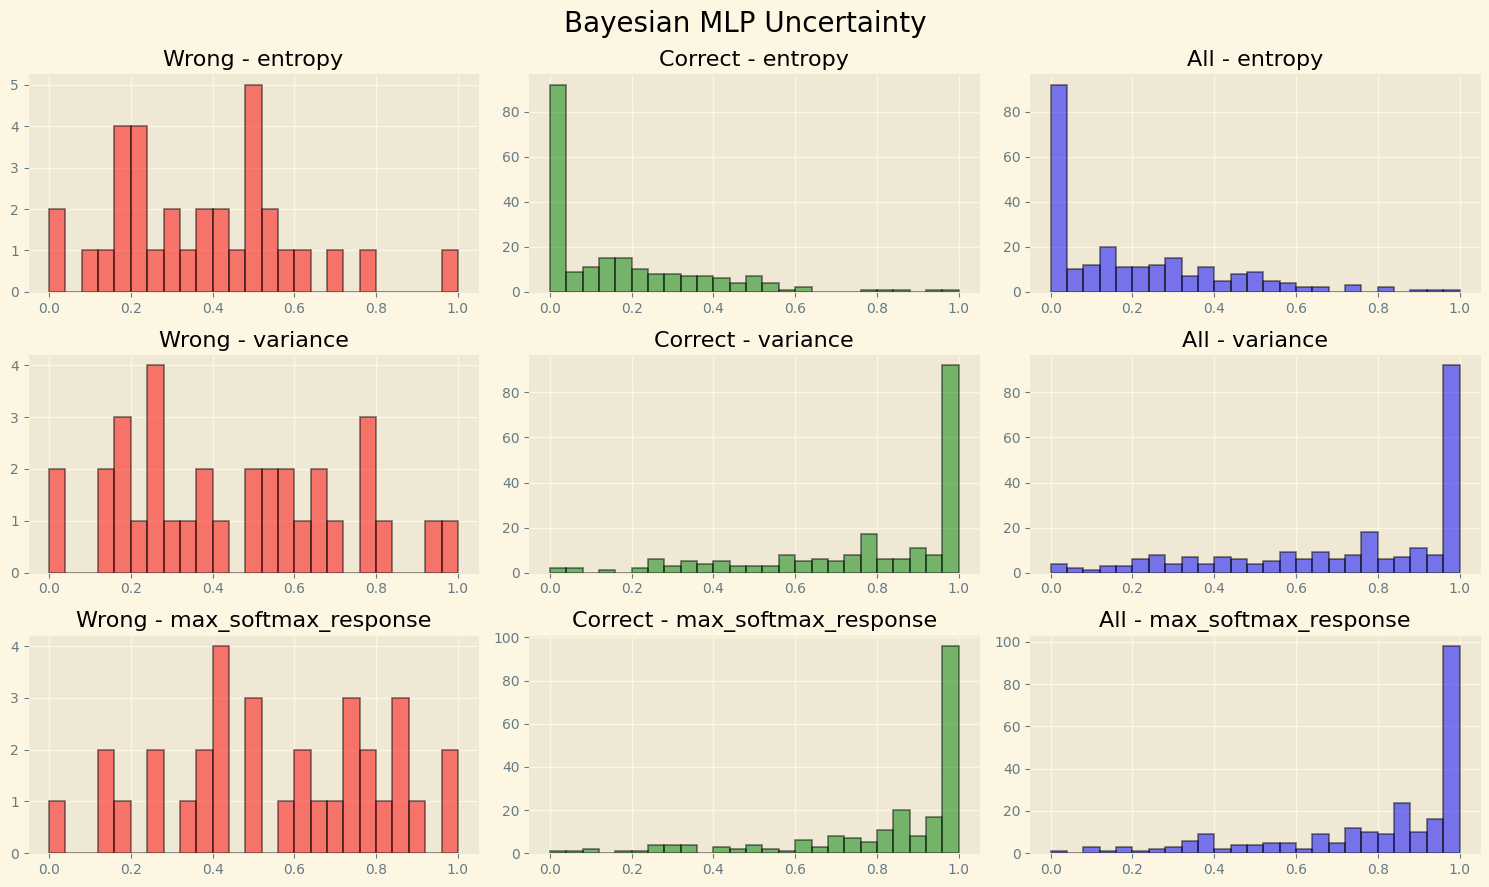

In [49]:
n_mc = 10
preds_list = [classifier.model.predict(X_test.values, verbose=0) for _ in range(n_mc)]
preds_array = np.array(preds_list)
print(preds_array.shape)
preds_bayes_mean = np.mean(preds_array, axis=0)

uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

In [50]:
# Assuming y_test_pred are your model predictions and y_test are the actual labels
# Note: if y_test_pred is in a one-hot encoded format, convert it to class labels first
y_pred_classes = y_test_pred.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7909836065573771
Precision: 0.7760519946003818
Recall: 0.7652679474835672
F1 Score: 0.7445419089284971


# Anomaly detection

In [51]:
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 73.04796051979065 seconds ---


10/10 [==============================] - 0s 2ms/step
Accuracy: 0.6372549019607843
Precision: 0.6984267854386701
Recall: 0.5835065710872162
F1 Score: 0.5971311285731968
(10, 306, 31)
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


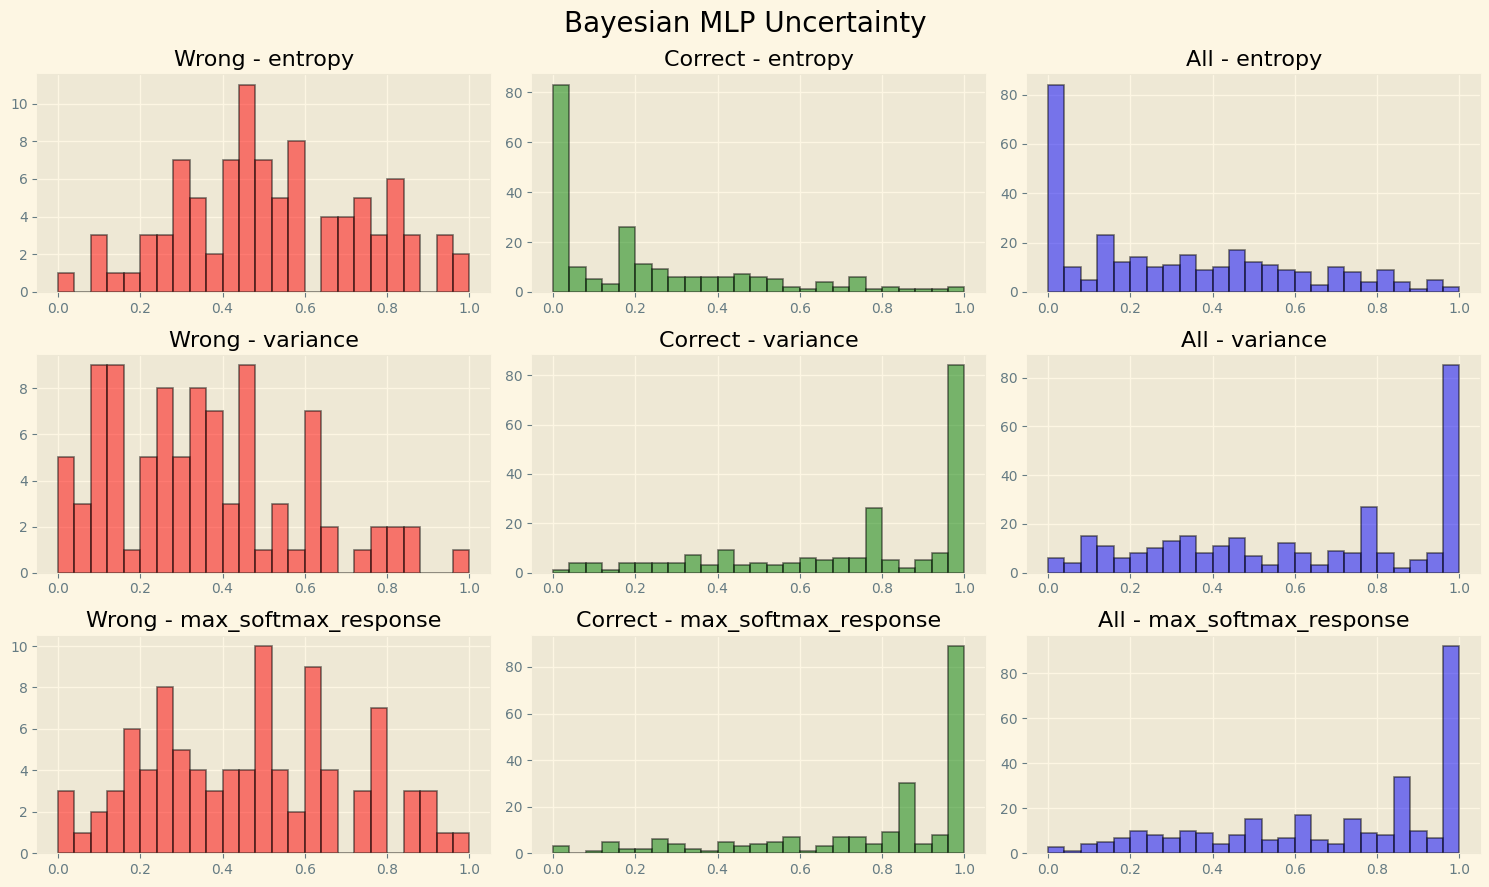

In [52]:
df_features_collision.isnull().values.any()
#df_features_collision_nonan = df_features_collision.drop((df_features_collision.columns[df_features_collision.isna().any()].tolist()), axis=1)
df_features_collision_nonan = df_features_collision.fillna(0)

X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)),
                           columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

# Assuming y_test_pred are your model predictions and y_test are the actual labels
# Note: if y_test_pred is in a one-hot encoded format, convert it to class labels first
y_test_pred_collision = classifier.predict(X_collision.values)
y_pred_classes = y_test_pred_collision.argmax(axis=1)

accuracy = accuracy_score(y_collision, y_pred_classes)
precision = precision_score(y_collision, y_pred_classes, average='macro')
recall = recall_score(y_collision, y_pred_classes, average='macro')
f1 = f1_score(y_collision, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

preds_list_collision = [classifier.model.predict(X_collision.values, verbose=0) for _ in range(n_mc)]
preds_array_collisions = np.array(preds_list_collision)
print(preds_array_collisions.shape)
preds_bayes_mean_collision = np.mean(preds_array_collisions, axis=0)

uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) == y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) != y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array_collisions.mean(axis=0)).compute_uncertainty_metrics()

plot_uncertainty(uncertainties_bayes, "Bayesian MLP Uncertainty")

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        12
           1       0.73      0.80      0.76        10
           2       1.00      0.22      0.36         9
           3       0.90      0.67      0.77        27
           4       0.93      0.72      0.81        18
           5       0.60      0.33      0.43         9
           6       1.00      0.44      0.62         9
           7       0.60      0.96      0.74        27
           8       0.46      0.94      0.62        18
           9       0.58      0.78      0.67         9
          10       0.57      0.44      0.50         9
          11       1.00      0.76      0.86        25
          12       0.87      0.81      0.84        16
          13       1.00      0.50      0.67         6
          14       0.75      0.50      0.60         6
          15       0.75      0.50      0.60         6
          16       0.67      0.33      

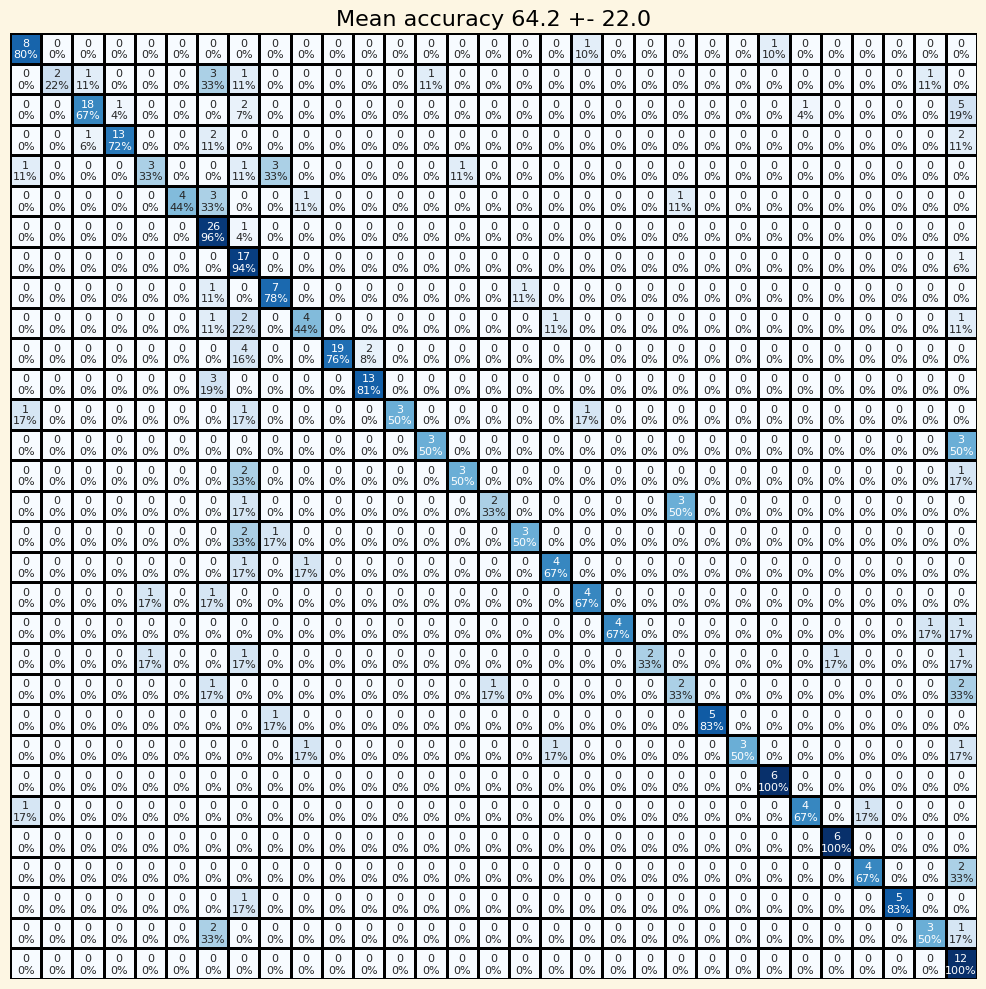

In [53]:
# Assuming you have y_collision as the true labels for the collision dataset
y_pred_collision_classes = preds_bayes_mean_collision.argmax(axis=1)

print("Confusion Matrix:")
create_and_plot_cm(preds_bayes_mean_collision, y_collision, action2int)

print("\nClassification Report:")
print(classification_report(y_collision, y_pred_collision_classes))

[0.0, 0.0, 0.0, 0.02010050251256279, 0.07537688442211055, 0.12562814070351758, 0.1758793969849246, 0.2211055276381909, 0.29145728643216084, 0.5025125628140703]
[0.009345794392523364, 0.037383177570093455, 0.18691588785046728, 0.34579439252336447, 0.45794392523364486, 0.5607476635514018, 0.6448598130841121, 0.7850467289719626, 0.9065420560747663, 0.9626168224299065]


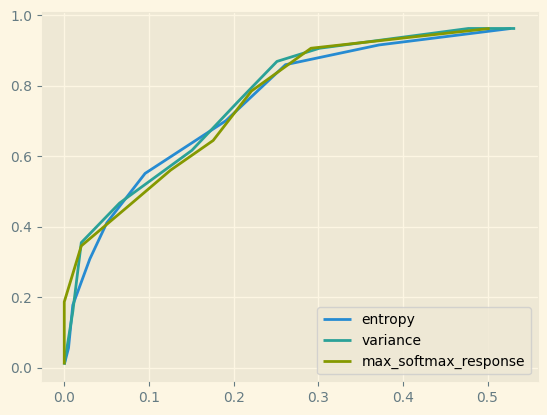

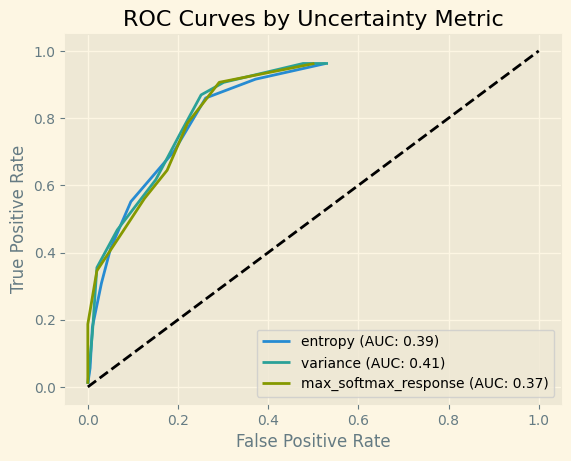

10/10 [==============================] - 0s 2ms/step
Missclassified samples: 0    False
1    False
2    False
3    False
4     True
     ...  
0    False
0     True
0     True
0     True
0     True
Name: label, Length: 306, dtype: bool
Number of Missclassified samples: 113
Total number of collisions: 107


In [54]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes['correct'].keys():
    confidence = uncertainties_bayes['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))
    roc_dict[confidence_metric] = (fpr, sens)


fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();

fig, ax = plt.subplots()

for confidence_metric, (fpr, sens) in roc_dict.items():
    ax.plot(fpr, sens, label=f'{confidence_metric} (AUC: {auc(fpr, sens):.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves by Uncertainty Metric')
ax.legend(loc='lower right')
plt.show()

y_pred_collision = classifier.predict(X_collision.values)
y_pred_collision_classes = y_pred_collision.argmax(axis=1)
missclassified = y_collision != y_pred_collision_classes
print(f"Missclassified samples: {missclassified}")
print(f"Number of Missclassified samples: {missclassified.sum()}")

total_collision = len(collisions_init)

print(f"Total number of collisions: {total_collision}")